<a href="https://colab.research.google.com/github/willystumblr/AI-ML_Team_5/blob/kms/NLP_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.6.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
print(imdb)
print("\n")
print(info)

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>, 'unsupervised': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}


tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),


In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

## Numpy library
C언어로 구현된 파이썬 라이브러리 

벡터 및 행렬 연산에 있어서 편리한 기능을 제공한다고 함. 

array라는 단위로 데이터를 관리하며 이에 대해 연산을 수행함.

* matplotlib
* pandas 

출처: https://doorbw.tistory.com/171

## Train/Test/Validation Set
### Train set
모델을 학습하기 위한 dataset이다. 한 가지 계속 명심해야할 중요한 사실은
> 모델을 학습하는데에는 오직 유일하게 Train dataset만 이용한다.

보통 train set을 이용해 각기 다른 모델을 서로 다른 epoch로 학습을 시킨다. 여기서 각기 다른 모델이란 hidden layer 혹은 hyper parameter에 약간씩 변화를 줌을 뜻한다.

### Test Set & Validation Set
* validation set: 학습이 이미 완료된 모델을 검증하기 위한 dataset
* test set: 학습과 검증이 완료된 모델의 성능을 평가하기 위한 dataset

보통 Train : Test 데이터를 8 : 2로 나누는데 여기서 Train 데이터 중 일부를 validation set으로 이용하여 Train : Validation : Test 을 일반적으로 6 : 2 : 2로 이용한다.

출처: https://ganghee-lee.tistory.com/38 

validation set과 test set의 공통점은 이 데이터를 통해 모델을 update 즉, 학습을 시키지 않는다는 것이다. 이렇게 validation set과 test set은 둘다 이미 학습을 완료한 모델에 대해 평가하고 학습을 시키지 않는데...

> 그렇다면 둘의 차이는 과연 무엇일까?

Validation set은 모델을 update, 즉 학습을 시키진 않지만 학습에 '관여'는 한다. 반면 Test set은 학습에 전혀 관여하지 않고 오직 '최종 성능'을 평가하기 위해 쓰인다.

In [4]:
# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

print(training_labels_final.shape)
print(testing_labels_final.shape)

(25000,)
(25000,)


In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


## Hyperparameter
A model hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data.

- They are often used in processes to help estimate model parameters.
- They are often specified by the practitioner.
- They can often be set using heuristics.
- They are often tuned for a given predictive modeling problem.

하이퍼 파라미터는 모델링할 때 **사용자가 직접 세팅해주는 값**을 뜻합니다. (They are often specified by the practitioner) learning rate나 서포트 벡터 머신에서의 C, sigma 값, KNN에서의 K값 등등 굉장히 많습니다. 머신러닝 모델을 쓸 때 사용자가 직접 세팅해야 하는 값은 상당히 많습니다. 그 모든 게 다 하이퍼 파라미터입니다. 하지만, 많은 사람들이 그런 값들을 조정할 때 그냥 '모델의 파라미터를 조정한다'라는 표현을 씁니다. 원칙적으로는 '모델의 하이퍼 파라미터를 조정한다'라고 해야 합니다.

하이퍼 파라미터는 정해진 최적의 값이 없습니다. 휴리스틱한 방법이나 경험 법칙(rules of thumb)에 의해 결정하는 경우가 많습니다. (They can often be set using heuristics) 베이지안 옵티미제이션과 같이 자동으로 하이퍼 파라미터를 선택해주는 라이브러리도 있긴 합니다.

파라미터와 하이퍼 파라미터를 구분하는 기준은 사용자가 직접 설정하느냐 아니냐입니다. 사용자가 직접 설정하면 하이퍼 파라미터, 모델 혹은 데이터에 의해 결정되면 파라미터입니다.


출처: [여기](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-13-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0Parameter%EC%99%80-%ED%95%98%EC%9D%B4%ED%8D%BC-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0Hyper-parameter)



In [11]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3])) 
print(training_sentences[3]) 

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


`decode_review(text)`의 역할: padding 된 부분의 빈 공간을 `?`로 채우는 것?

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


## 활성화함수
딥러닝 네트워크에서 노드에 입력된 값들을 비선형 함수에 통과시킨 후 다음 레이어로 전달하는데, 이 때 사용하는 함수를 활성화 함수(Activation Function)라고 한다. 인공신경망에서 활성화 함수는 입력 데이터를 다음 레이어로 어떻게 출력하느냐를 결정하는 역할이기 때문에 매우 중요하다.
### ReLU 
![image.png](https://mblogthumb-phinf.pstatic.net/MjAyMDAyMjVfOTIg/MDAxNTgyNjA4MzI2NDA5.e0VyX0yrhE5gtfPjni7IxF5kpArCeByreQsdOMB0240g.CWwTi57bPtAK6C7eLmRn1ED2RE8Lm_C6sVIwMGJS1Akg.PNG.handuelly/image.png?type=w800)

x가 0보다 크면 기울기가 1인 직선, 0보다 작으면 함수 값이 0이 됨.

### Sigmoid 
![image.png](https://mblogthumb-phinf.pstatic.net/MjAyMDAyMjVfMjI4/MDAxNTgyNjA3MjY0NzIy.tR76IK8YsIL8XORjYDJoMSNBK2nhpUooUhMS6N0d1NUg.bMGce-shmpX6--ck-mvfcTimMjL3UpFw2iSgQgExCR8g.PNG.handuelly/image.png?type=w800)

Logistic 함수라고 불리기도 하며, x의 값에 따라 0~1의 값을 출력하는 S자형 함수이다.

In [14]:
num_epochs = 20
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/20
782/782 [==============================] - 6s 8ms/step - loss: 9.4803e-05 - accuracy: 1.0000 - val_loss: 0.8397 - val_accuracy: 0.8272
Epoch 2/20
782/782 [==============================] - 6s 7ms/step - loss: 5.8522e-05 - accuracy: 1.0000 - val_loss: 0.8744 - val_accuracy: 0.8271
Epoch 3/20
782/782 [==============================] - 7s 9ms/step - loss: 3.6345e-05 - accuracy: 1.0000 - val_loss: 0.9094 - val_accuracy: 0.8267
Epoch 4/20
782/782 [==============================] - 7s 9ms/step - loss: 2.3100e-05 - accuracy: 1.0000 - val_loss: 0.9428 - val_accuracy: 0.8267
Epoch 5/20
782/782 [==============================] - 7s 9ms/step - loss: 1.4718e-05 - accuracy: 1.0000 - val_loss: 0.9819 - val_accuracy: 0.8266
Epoch 6/20
782/782 [==============================] - 7s 9ms/step - loss: 9.2451e-06 - accuracy: 1.0000 - val_loss: 1.0119 - val_accuracy: 0.8258
Epoch 7/20
782/782 [==============================] - 6s 7ms/step - loss: 7.0696e-06 - accuracy: 1.0000 - val_loss: 1.0505 -

## for 10 epochs...

`Epoch 1/10
782/782 [==============================] - 10s 9ms/step - loss: 0.5049 - accuracy: 0.7328 - val_loss: 0.3418 - val_accuracy: 0.8493`

`Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.2371 - accuracy: 0.9086 - val_loss: 0.3750 - val_accuracy: 0.8390`

`Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0834 - accuracy: 0.9796 - val_loss: 0.4582 - val_accuracy: 0.8284`

`Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0191 - accuracy: 0.9980 - val_loss: 0.5395 - val_accuracy: 0.8261`

`Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 0.6024 - val_accuracy: 0.8260`

`Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.6499 - val_accuracy: 0.8270`

`Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 8.4575e-04 - accuracy: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.8273`

`Epoch 8/10
782/782 [==============================] - 7s 9ms/step - loss: 4.4742e-04 - accuracy: 1.0000 - val_loss: 0.7298 - val_accuracy: 0.8275`

`Epoch 9/10
782/782 [==============================] - 6s 7ms/step - loss: 2.5462e-04 - accuracy: 1.0000 - val_loss: 0.7671 - val_accuracy: 0.8276`

`Epoch 10/10
782/782 [==============================] - 7s 9ms/step - loss: 1.5567e-04 - accuracy: 1.0000 - val_loss: 0.8054 - val_accuracy: 0.8278`

`<keras.callbacks.History at 0x7f60f8da7650>`

20번 후...
* loss: 3.0485e-08
* accuracy: 1.0000
* val_loss: 1.4565
* val_accuracy: 0.8252

In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [16]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [17]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

다운된 파일을 Embedding projector로 열어보면...
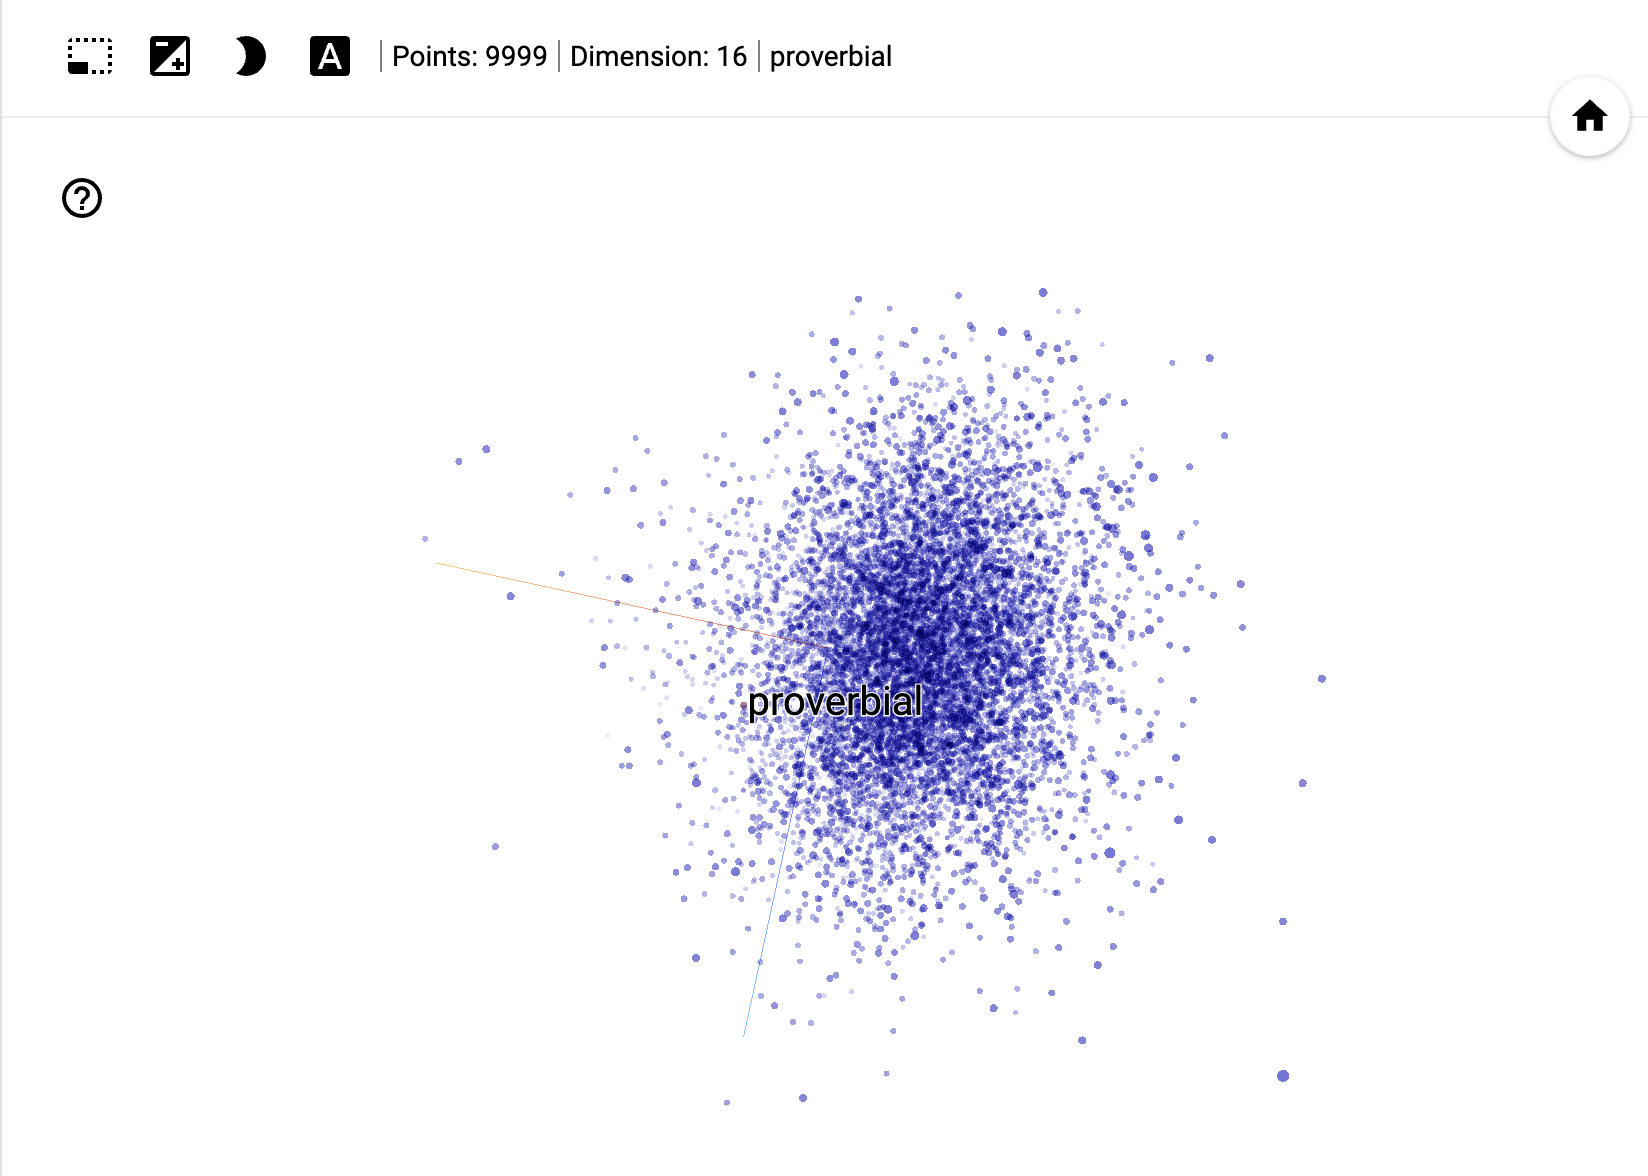





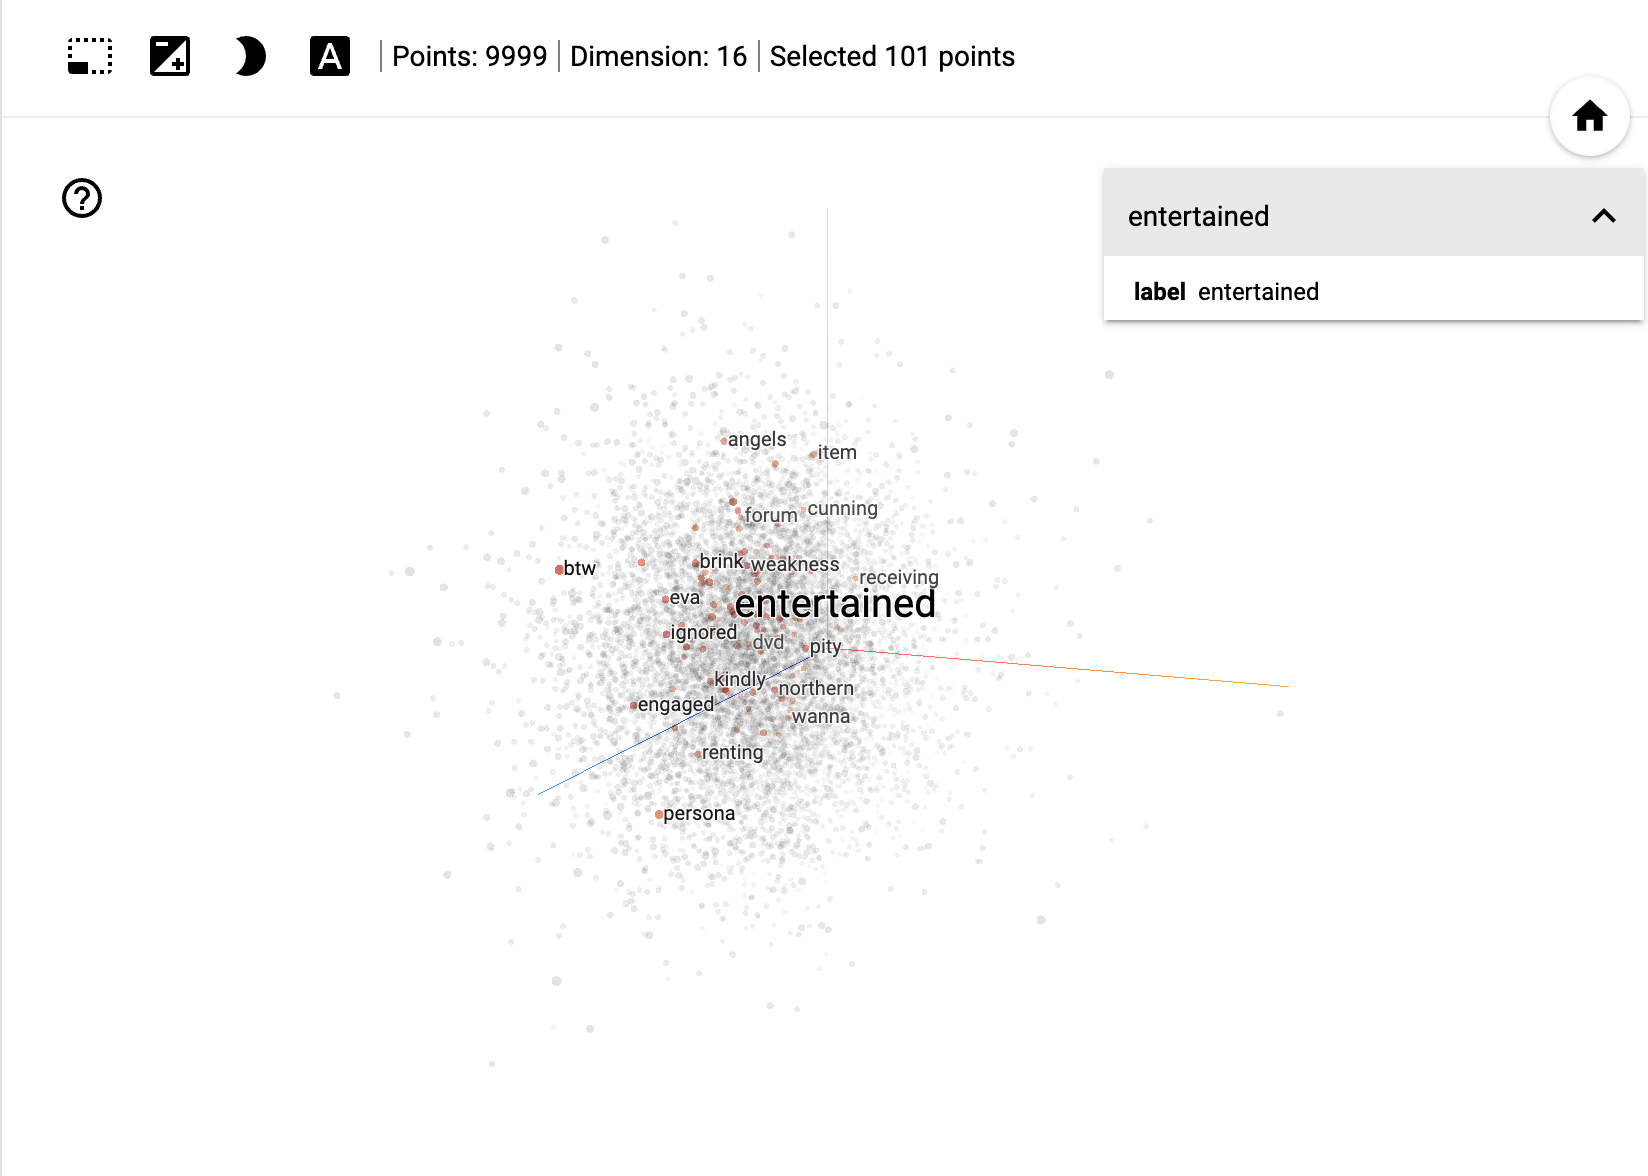

In [18]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]
